In [1]:
import cv2
import dask as d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob

In [2]:
from fl_tissue_model_tools import dev_config, defs, data_prep
from fl_tissue_model_tools import preprocessing as prep
from fl_tissue_model_tools import analysis as an

In [3]:
dirs = dev_config.get_dev_directories("../../dev_paths.txt")

In [4]:
proj = "2022_05_06_GFP_Ines_Cadena"
cell_image_dir = f"{dirs.data_dir}/coverage_area/{proj}"
thresh_cell_image_output_dir = f"{dirs.figures_dir}/coverage_area/{proj}"
cell_image_area_output_dir = f"{dirs.analysis_dir}/coverage_area/{proj}"

In [5]:
# Make write-out directories or overwrite them
data_prep.make_dir(thresh_cell_image_output_dir)
data_prep.make_dir(cell_image_area_output_dir)

In [12]:
dsamp_size = 250
sd_coef = 0 # threshold takes all pixels {sd_coefs} standard deviations above the mean of the foreground Gaussian
pinhole_buffer = 0.04
# pinhole_cut = 10 # the radius of the circle mask is ({dsamp_size}//2 -  {pinhole_cut})
pinhole_cut = int(round(dsamp_size * pinhole_buffer))

# Functions

In [13]:
def load_img(img_name, dsamp=True, dsize=250):
    """Load and downsample image.
    
    """
    # cv.IMREAD_ANYDEPTH loads the image as a 16 bit grayscale image
    img = cv2.imread(img_name, cv2.IMREAD_ANYDEPTH)
    if dsamp:
        img = cv2.resize(img, dsize, cv2.INTER_AREA)
    return img


def load_and_norm(img_name, a, b, mn, mx, dsamp=True, dsize=250):
    """ Load and normalize image to new range.
    
    """
    img = load_img(img_name, dsamp=True, dsize=dsize)
    return prep.min_max_(img, a, b, mn, mx)


def mask_and_threshold(img, circ_mask, pinhole_idx, sd_coef, rs):
    """Apply circle mask to image and perform foreground thresholding on the masked image.
    
    """
    masked = prep.apply_mask(img, circ_mask).astype(float)
    return prep.exec_threshold(masked, pinhole_idx, sd_coef, rs)


# Retrieve images

In [14]:
img_names = [img.replace("\\", "/") for img in glob(f"{cell_image_dir}/*.tif")]

In [15]:
gs_ds_imgs = d.compute(
    [d.delayed(load_and_norm)(img_n, 0, defs.GS_MAX, 0, defs.TIF_MAX, dsamp=True, dsize=(dsamp_size, dsamp_size)) for img_n in img_names]
)[0]

In [16]:
# variables for image masking
img_shape = gs_ds_imgs[0].shape
img_center = (img_shape[0] // 2, img_shape[1] // 2)
circ_rad = img_center[0] - (pinhole_cut)
circ_mask = prep.gen_circ_mask(img_center, circ_rad, img_shape, defs.GS_MAX)
pinhole_idx = np.where(circ_mask > 0)
circ_pix_area = np.sum(circ_mask > 0)

In [17]:
rs_all = np.random.RandomState(seed=123)
gmm_thresh_all = d.compute(
    [d.delayed(mask_and_threshold)(img, circ_mask, pinhole_idx, sd_coef, rs_all)
     for img in gs_ds_imgs]
)[0]

In [22]:
area_prop = d.compute(
    [d.delayed(an.compute_area_prop)(gimg, circ_pix_area) for gimg in gmm_thresh_all]
)[0]
area_prop = np.array(area_prop)

In [24]:
img_ids = [img_n.split("/")[-1] for img_n in img_names]
area_df = pd.DataFrame(
    data = {"image_id": img_ids, "area_pct": area_prop * 100}
)

In [27]:
target_idx = 55

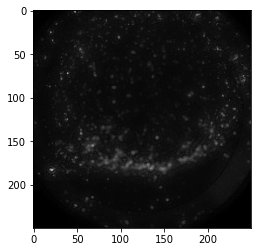

In [28]:
plt.imshow(gs_ds_imgs[target_idx], cmap="gray")
plt.show()

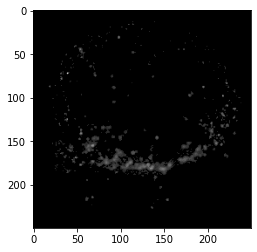

In [30]:
plt.imshow(gmm_thresh_all[target_idx], cmap="gray")
plt.show()

# Save results

In [37]:
for i in range(len(img_ids)):
    cv2.imwrite(
        f"{thresh_cell_image_output_dir}/{img_ids[i]}_thresholded.tif",
        prep.min_max_(gmm_thresh_all[i], 0, defs.TIF_MAX, 0, defs.GS_MAX).astype(np.uint16)
    )
area_df.to_csv(f"{cell_image_area_output_dir}/area_results.csv", index=False)